In [45]:
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import os
import matplotlib.pyplot as plt  # plotting tools
%matplotlib inline
import pickle
import numpy as np
import geopandas as gps
import pandas as pd
import math

In [46]:
def draw_distribution(prediction_with_commission,label_with_omission):
    fig, axes = plt.subplots(3,1, figsize=(10,9), sharex=False, sharey=False, dpi=300)
    prediction_with_commission.plot(kind='scatter',x='area',y='commission',ax=axes[0],color='b',s=1,alpha=0.1)
    axes[0].set_xlabel('area of predicted polygon ($km^2$)')
    axes[0].set_xlim([0.00001,20])
    axes[0].set_xscale('log')
    axes[0].xaxis.set_major_formatter(plt.NullFormatter())
    label_with_omission.plot(kind='scatter',x='area',y='omission',ax=axes[1],color='r',s=1,alpha=0.1)#,label='({},{}]'.format(area[0],area[1])
    axes[1].set_xlabel('area of label polygon ($km^2$)')
    axes[1].set_xlim([0.00001,20])
    axes[1].set_xscale('log')
    axes[1].xaxis.set_major_formatter(plt.NullFormatter())
    # plt.xlabel('area of label polygon ($km^2$)')
    axes[2].hist([prediction_with_commission['area']],bins=[0.00001,0.0001,0.001,0.01,0.1,1,10,20],color='b',alpha=0.5,label='predicted polygon')
    axes[2].hist(label_with_omission['area'],bins=[0.00001,0.0001,0.001,0.01,0.1,1,10,20],color='r',alpha=0.5,label='label polygon')
    # axes[2].set_yscale('log')
    axes[2].set_ylabel('count')
    axes[2].set_xlabel('area of lake ($km^2$)')
    axes[2].legend()
    axes[2].set_xlim([0.00001,20])
    axes[2].set_ylim([0,18000])
    axes[2].set_xscale('log')
    plt.suptitle(version)
    plt.savefig(os.path.join(base_dir,'lake_error_distribution_{}.png'.format(version)),bbox_inches='tight',pad_inches = 0.1)

In [47]:
columns=['polygon_size','label_sum_area','label_num','omission≤0.05','omission≥0.95','total_omission','prediction_sum_area','prediction_num','commission≤0.05','commission≥0.95','total_commission']
evaluate=pd.DataFrame(columns=columns)
def cal_csv(label_with_omission,prediction_with_commission):
    for i in range(0,8):
        area=area_size_list[i]
        polygon_size='({},{}]'.format(area[0],area[1])
        sel_label_with_omission=label_with_omission.query('area > {} and area < {}'.format(area[0],area[1]))
        label_sum_area=sel_label_with_omission['area'].sum()
        label_num=sel_label_with_omission['area'].count()
        total_omission=sel_label_with_omission['area_1'].sum()/label_sum_area*100
        om_lte0_05_pre=len(sel_label_with_omission[sel_label_with_omission.omission<=0.05])*100.0/label_num
        om_gt0_95_pre=len(sel_label_with_omission[sel_label_with_omission.omission>0.95])*100.0/label_num

        sel_prediction_with_commission=prediction_with_commission.query('area>{} and area<{}'.format(area[0],area[1]))
        prediction_sum_area=sel_prediction_with_commission['area'].sum()
        prediction_num=sel_prediction_with_commission['area'].count()
        total_commission=sel_prediction_with_commission['area_1'].sum()/prediction_sum_area*100
        co_lte0_05_pre=len(sel_prediction_with_commission[sel_prediction_with_commission.commission <=0.05])*100.0/prediction_num
        co_gt0_95_pre=len(sel_prediction_with_commission[sel_prediction_with_commission.commission > 0.95])*100.0/prediction_num
        evaluate.loc[i]=[polygon_size,label_sum_area,label_num,om_lte0_05_pre,om_gt0_95_pre,total_omission,prediction_sum_area,prediction_num,co_lte0_05_pre,co_gt0_95_pre,total_commission]
    evaluate.to_csv(os.path.join(base_dir,'evaluate_{}.csv'.format(version)),index=False)
    return evaluate

In [59]:
base_dir = 'D:/evaluate/model_576_240121'#'D:\evaluate'
version = 'iew100'
evaluation_dir = os.path.join(base_dir,'label')
predicted_polygon_dir=os.path.join(base_dir,version)
area_size_list=[[0,0.001],[0.001,0.01],[0.01,0.1],[0.1,1],[1,20],[0.001,0.005],[0.005,0.01],[0,20]]#
bins=[0,0.001,0.01,0.1,1,10]

In [37]:
# fig, axes = plt.subplots(2,3, figsize=(18,12), sharex=False, sharey=True, dpi=300)
# for i, ax in enumerate(axes.ravel()):
#     area=area_size_list[i]
#     suffix=str(area[1]).replace('.','_')
#     label_polygon=gps.read_file(os.path.join(predicted_polygon_dir,'label_polygons_lte{}.shp'.format(suffix)))
#     label_polygon.plot(kind='scatter',x='AREA',y='omission',ax=ax,color='blue',s=0.5,alpha=0.5)
#     ice_lake=label_polygon[label_polygon['CLASS_NAME']=='IceLake']
#     reservoir=label_polygon[label_polygon['CLASS_NAME']=='Reservoir']
#     lake_like_river=label_polygon[label_polygon['CLASS_NAME']=='LakeLikeRiver']
#     other_lake=label_polygon[label_polygon['CLASS_NAME']=='Lake']
    
#     ice_lake.plot(kind='scatter',x='AREA',y='omission',ax=ax,color='red',s=2,alpha=0.5,label='ice_lake')
#     reservoir.plot(kind='scatter',x='AREA',y='omission',ax=ax,color='orange',s=2,alpha=0.5,label='reservoir')
#     lake_like_river.plot(kind='scatter',x='AREA',y='omission',ax=ax,color='green',s=2,alpha=0.5,label='lake like river')
#     other_lake.plot(kind='scatter',x='AREA',y='omission',ax=ax,color='blue',s=1,alpha=0.5,label='other lake')
#     ax.scatter(label_polygon.AREA,label_polygon.omission,s=0.5)
#     ax.set_xlabel('label area')
#     ax.set_ylabel('omission')
#     ax.set_xlim(area)
#     ax.set_ylim([0,1])
#     ax.set_title('{}<label area<={} ($km^2$)'.format(area[0],area[1]))
    
#     if i!=5:
#         ax.get_legend().remove()

In [27]:
# fig, ax = plt.subplots(1,1, figsize=(18,12), sharex=True, sharey=True, dpi=300)
# for i, ax in enumerate(axes.ravel()):
#     area=area_size_list[i]
#     suffix=str(area[1]).replace('.','_')
#     label_polygon=gps.read_file(os.path.join(predicted_polygon_dir,'label_polygons_lte{}.shp'.format(suffix)))
# #     data=pd.Seties(label_polygon['omission'])
#     count=label_polygon['omission'].count()
#     label_polygon['omission'].hist(bins=np.arange(0,1,0.05),ax=ax,weights=[1./count]*count)
#     ax.set_title('{} $km^2$< label area <={} $km^2$'.format(area[0],area[1]))
#     if i==0 or i==3:
#         ax.set_ylabel('percentage')
#     if i>=3:
#         ax.set_xlabel('omission error')

In [12]:
# colors = {0:'red', 1:'orange', 2:'green', 3:'blue',4:'purple',5:'black'}
# fig, ax = plt.subplots(1,1, figsize=(10,3), sharex=False, sharey=True, dpi=300)
# for i in range(0,6):
#     area=area_size_list[i]
#     suffix=str(area[1]).replace('.','_')
#     label_polygon=gps.read_file(os.path.join(predicted_polygon_dir,'label_polygons_lte{}.shp'.format(suffix)))
#     sel_polygon=label_polygon[label_polygon['omission']!=0]
#     sel_polygon.plot(kind='scatter',x='AREA',y='omission',ax=ax,color=colors[3],s=1,alpha=0.2)#,label='({},{}]'.format(area[0],area[1])
# plt.xscale('log')
# plt.xlabel('area of label polygon ($km^2$)')

In [13]:
# fig = plt.figure(figsize=(4,3), dpi=100) #inch
# commission_polygon=gps.read_file(os.path.join(predicted_polygon_dir,'commission_polygons_not_interactwith_label.shp'))
# commission_polygon['area'].hist(bins=bins)
# plt.xscale('log')
# # plt.yscale('log')
# plt.ylabel('count')
# plt.xlabel('area')
# plt.title(' distribution of commission polygons\n which not interact with true label')

In [60]:
prediction_with_commission=gps.read_file(os.path.join(predicted_polygon_dir,'prediction_with_commission.shp'))
label_with_omission=gps.read_file(os.path.join(predicted_polygon_dir,'label_with_omission.shp'))
# prediction_with_commission

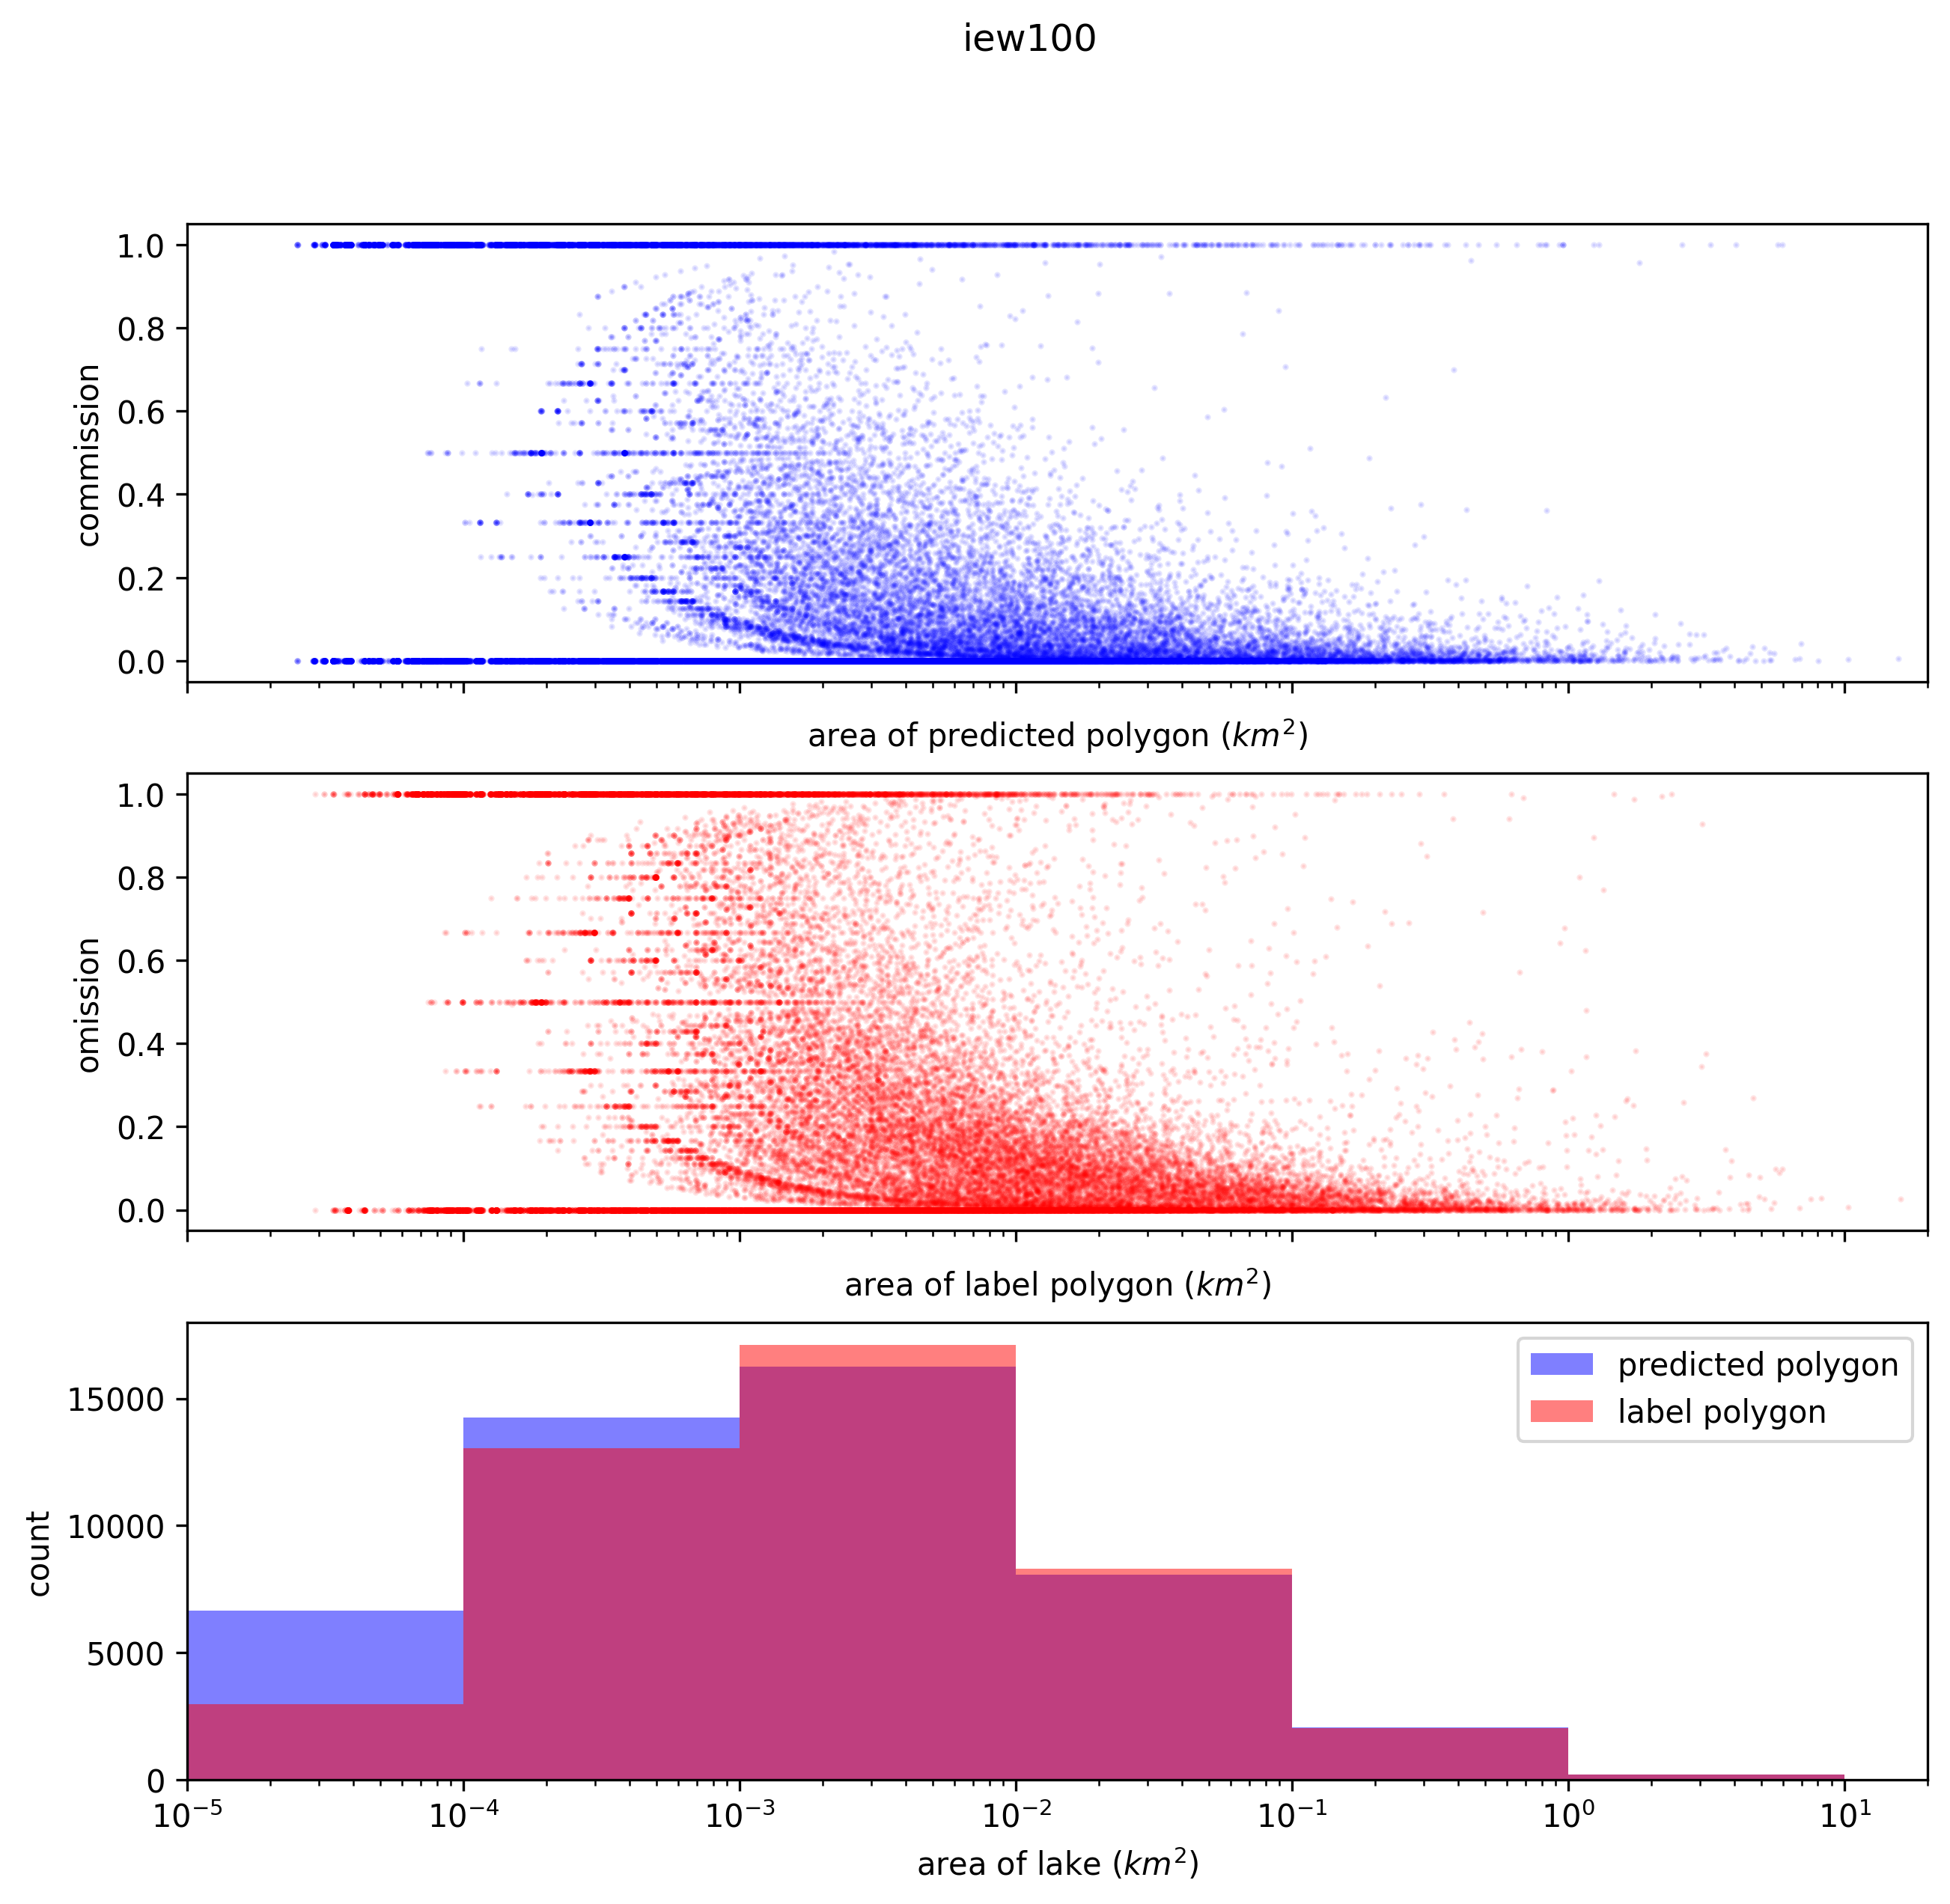

In [61]:
draw_distribution(prediction_with_commission,label_with_omission)

In [58]:
print(version)
evaluate=cal_csv(label_with_omission,prediction_with_commission)
evaluate

iew100


,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.373248,16019,32.367813,44.915413,49.806006,6.346993,20321,53.698145,35.957876,33.288884
1,"(0.001,0.01]",63.160063,17106,36.764878,8.844850,22.817540,60.110964,16398,60.476887,8.061959,13.469075
2,"(0.01,0.1]",263.521537,8308,47.063072,1.998074,9.678023,257.450323,8107,75.502652,3.466140,6.445243
3,"(0.1,1]",578.222803,2036,70.972495,1.178782,5.778523,575.368912,2060,86.504854,3.058252,5.022316
4,"(1,20]",474.292615,226,80.973451,1.769912,7.286546,467.149302,219,89.041096,3.196347,7.742098
5,"(0.001,0.005]",30.723942,12560,36.011146,10.398089,27.249115,29.316810,12076,58.007618,9.100696,16.270292
6,"(0.005,0.01]",32.436122,4546,38.847338,4.553454,18.619892,30.794154,4322,67.376215,5.159648,10.802246
7,"(0,20]",1385.570267,43695,38.933516,20.373040,8.015602,1366.426494,47105,61.409617,19.063794,6.723123


In [62]:
print(version)
evaluate=cal_csv(label_with_omission,prediction_with_commission)
evaluate

iew100


,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.373248,16019,37.424309,41.151133,46.323710,6.630569,20908,51.100057,37.258466,35.148889
1,"(0.001,0.01]",63.160063,17106,40.330878,8.651935,21.559469,59.769314,16253,58.130807,7.457085,13.692285
2,"(0.01,0.1]",263.521537,8308,53.322099,2.094367,8.716198,256.951176,8079,71.729174,2.710732,6.237454
3,"(0.1,1]",578.222803,2036,79.764244,1.031434,4.863767,577.108994,2064,83.333333,2.567829,5.299328
4,"(1,20]",474.292615,226,78.761062,1.769912,7.052173,474.099767,224,87.053571,3.571429,6.954137
5,"(0.001,0.005]",30.723942,12560,39.482484,10.111465,25.849315,29.258888,11985,55.794743,8.710889,16.878357
6,"(0.005,0.01]",32.436122,4546,42.674879,4.619446,17.496067,30.510426,4268,64.690722,3.936270,10.636907
7,"(0,20]",1385.570267,43695,43.771599,18.928939,7.297335,1374.559820,47528,58.580205,19.529540,6.554390


In [63]:
ie0=pd.read_csv(r'D:\evaluate\model_576_240121\evaluate_iew0.csv')
ie0

,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.373248,16019,37.511705,40.957613,45.986473,6.777924,21434,49.589437,38.695530,36.247711
1,"(0.001,0.01]",63.160063,17106,40.827780,8.657781,21.481797,59.933771,16348,56.961096,8.056031,14.366387
2,"(0.01,0.1]",263.521537,8308,53.478575,2.106403,8.797875,257.839699,8127,71.182478,3.125385,6.642308
3,"(0.1,1]",578.222803,2036,79.125737,0.982318,5.040684,580.098888,2082,83.093180,2.881844,5.501819
4,"(1,20]",474.292615,226,76.548673,1.769912,7.388018,473.205726,224,86.607143,4.464286,7.603961
5,"(0.001,0.005]",30.723942,12560,40.031847,10.103503,25.755233,29.404499,12066,54.516824,9.373446,17.774826
6,"(0.005,0.01]",32.436122,4546,43.026837,4.663440,17.433939,30.529272,4282,63.848669,4.343765,11.083524
7,"(0,20]",1385.570267,43695,43.986726,18.860281,7.496571,1377.856009,48215,57.347299,20.605621,6.974026


In [31]:
ie0=pd.read_csv(r'D:\evaluate\model_768_240116\evaluate_iew0.csv')
ie0

,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.355001,15947,39.932276,37.737505,42.621247,7.176135,22564,44.854636,44.207587,41.025172
1,"(0.001,0.01]",63.011227,17064,41.783872,6.885842,18.987541,63.342122,17384,54.647952,10.659227,16.989843
2,"(0.01,0.1]",262.941657,8287,52.636660,1.641125,8.172855,266.444102,8434,70.026085,5.382974,8.779766
3,"(0.1,1]",576.585388,2029,75.505175,1.182849,5.622729,590.346278,2114,82.639546,4.872280,6.750449
4,"(1,20]",474.292615,226,79.203540,2.654867,8.397877,450.922438,211,89.099526,3.791469,5.865122
5,"(0.001,0.005]",30.643027,12527,41.159096,8.062585,22.604614,31.353639,12894,52.210330,12.067628,20.642407
6,"(0.005,0.01]",32.368200,4537,43.508927,3.636764,15.563251,31.988483,4490,61.648107,6.614699,13.409768
7,"(0,20]",1383.185887,43553,44.936055,16.896655,7.837923,1378.231076,50707,54.158203,24.440413,7.502160


In [34]:
ie0=pd.read_csv(r'D:\evaluate\model_576_240118\evaluate_iew0.csv')
ie0

,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.373248,16019,32.898433,44.497160,49.354016,6.482146,20933,52.519945,37.276071,34.662180
1,"(0.001,0.01]",63.160063,17106,37.378698,8.751315,22.570083,60.679796,16560,59.541063,8.737923,14.089499
2,"(0.01,0.1]",263.521537,8308,47.183438,1.841598,9.618730,260.754085,8213,74.479484,4.492877,7.461546
3,"(0.1,1]",578.222803,2036,71.316306,1.277014,5.945300,581.316063,2081,86.112446,3.507929,5.485375
4,"(1,20]",474.292615,226,78.761062,1.769912,7.687408,462.006925,215,89.767442,3.255814,7.868742
5,"(0.001,0.005]",30.723942,12560,36.640127,10.310510,26.993388,29.678214,12207,56.975506,9.895961,17.137535
6,"(0.005,0.01]",32.436122,4546,39.419270,4.443467,18.380268,31.001582,4353,66.735585,5.490466,11.171576
7,"(0,20]",1385.570267,43695,39.395812,20.157913,8.197783,1371.239015,48002,60.322487,20.205408,7.182856


In [41]:
ie50=pd.read_csv(r'D:\evaluate\model_576_240118\evaluate_iew50.csv')
ie50

,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.373248,16019,32.186778,45.083963,49.856962,6.368909,20451,53.503496,36.306293,33.696704
1,"(0.001,0.01]",63.160063,17106,36.870104,8.874079,22.778826,59.985159,16386,60.447943,8.067863,13.500295
2,"(0.01,0.1]",263.521537,8308,47.436206,1.986038,9.703317,257.385762,8106,75.524303,3.528251,6.567502
3,"(0.1,1]",578.222803,2036,71.365422,1.178782,5.809998,576.492590,2065,86.392252,3.099274,5.084773
4,"(1,20]",474.292615,226,80.530973,1.769912,7.342197,466.157543,218,89.449541,3.211009,7.694927
5,"(0.001,0.005]",30.723942,12560,36.162420,10.461783,27.209324,29.295579,12081,57.975333,9.121761,16.266315
6,"(0.005,0.01]",32.436122,4546,38.825341,4.487462,18.582197,30.689580,4305,67.386760,5.110337,10.859915
7,"(0,20]",1385.570267,43695,38.995308,20.443987,8.051067,1366.389962,47226,61.296743,19.277517,6.757363


In [42]:
ie75=pd.read_csv(r'D:\evaluate\model_576_240118\evaluate_iew75.csv')
ie75

,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.373248,16019,32.442724,45.183844,49.887358,6.372445,20351,53.948209,35.870473,33.398309
1,"(0.001,0.01]",63.160063,17106,36.770724,8.827312,22.825678,60.099658,16379,60.492094,7.991941,13.474722
2,"(0.01,0.1]",263.521537,8308,47.159364,1.986038,9.745356,257.232296,8092,75.593178,3.608502,6.478627
3,"(0.1,1]",578.222803,2036,71.267191,1.129666,5.833498,579.019723,2072,86.245174,3.137066,4.995472
4,"(1,20]",474.292615,226,80.530973,1.769912,7.261987,463.004836,216,89.814815,3.240741,7.722062
5,"(0.001,0.005]",30.723942,12560,36.058917,10.406051,27.209518,29.327218,12065,58.077082,8.968090,16.111761
6,"(0.005,0.01]",32.436122,4546,38.737352,4.465464,18.673245,30.772440,4314,67.246175,5.261938,10.961532
7,"(0,20]",1385.570267,43695,38.993020,20.460007,8.043689,1365.728958,47110,61.526215,19.046911,6.704841


In [43]:
ie92=pd.read_csv(r'D:\evaluate\model_576_240118\evaluate_iew92.csv')
ie92

,polygon_size,label_sum_area,label_num,omission≤0.05,omission≥0.95,total_omission,prediction_sum_area,prediction_num,commission≤0.05,commission≥0.95,total_commission
0,"(0,0.001]",6.373248,16019,32.180536,45.090205,49.894923,6.393464,20553,54.006714,35.843916,33.473150
1,"(0.001,0.01]",63.160063,17106,36.624576,8.844850,22.848766,60.193456,16438,60.518311,8.224845,13.639801
2,"(0.01,0.1]",263.521537,8308,46.942706,1.961964,9.696061,257.042800,8098,75.796493,3.420598,6.373899
3,"(0.1,1]",578.222803,2036,71.463654,1.129666,5.837166,576.329031,2064,86.191860,3.052326,4.966708
4,"(1,20]",474.292615,226,80.088496,1.769912,7.320018,464.952270,217,90.783410,3.225806,7.659880
5,"(0.001,0.005]",30.723942,12560,35.907643,10.414013,27.268885,29.334964,12104,58.096497,9.236616,16.352276
6,"(0.005,0.01]",32.436122,4546,38.605367,4.509459,18.661967,30.858492,4334,67.281957,5.399169,11.061246
7,"(0,20]",1385.570267,43695,38.805355,20.427967,8.056795,1364.911021,47370,61.562170,19.138695,6.665151


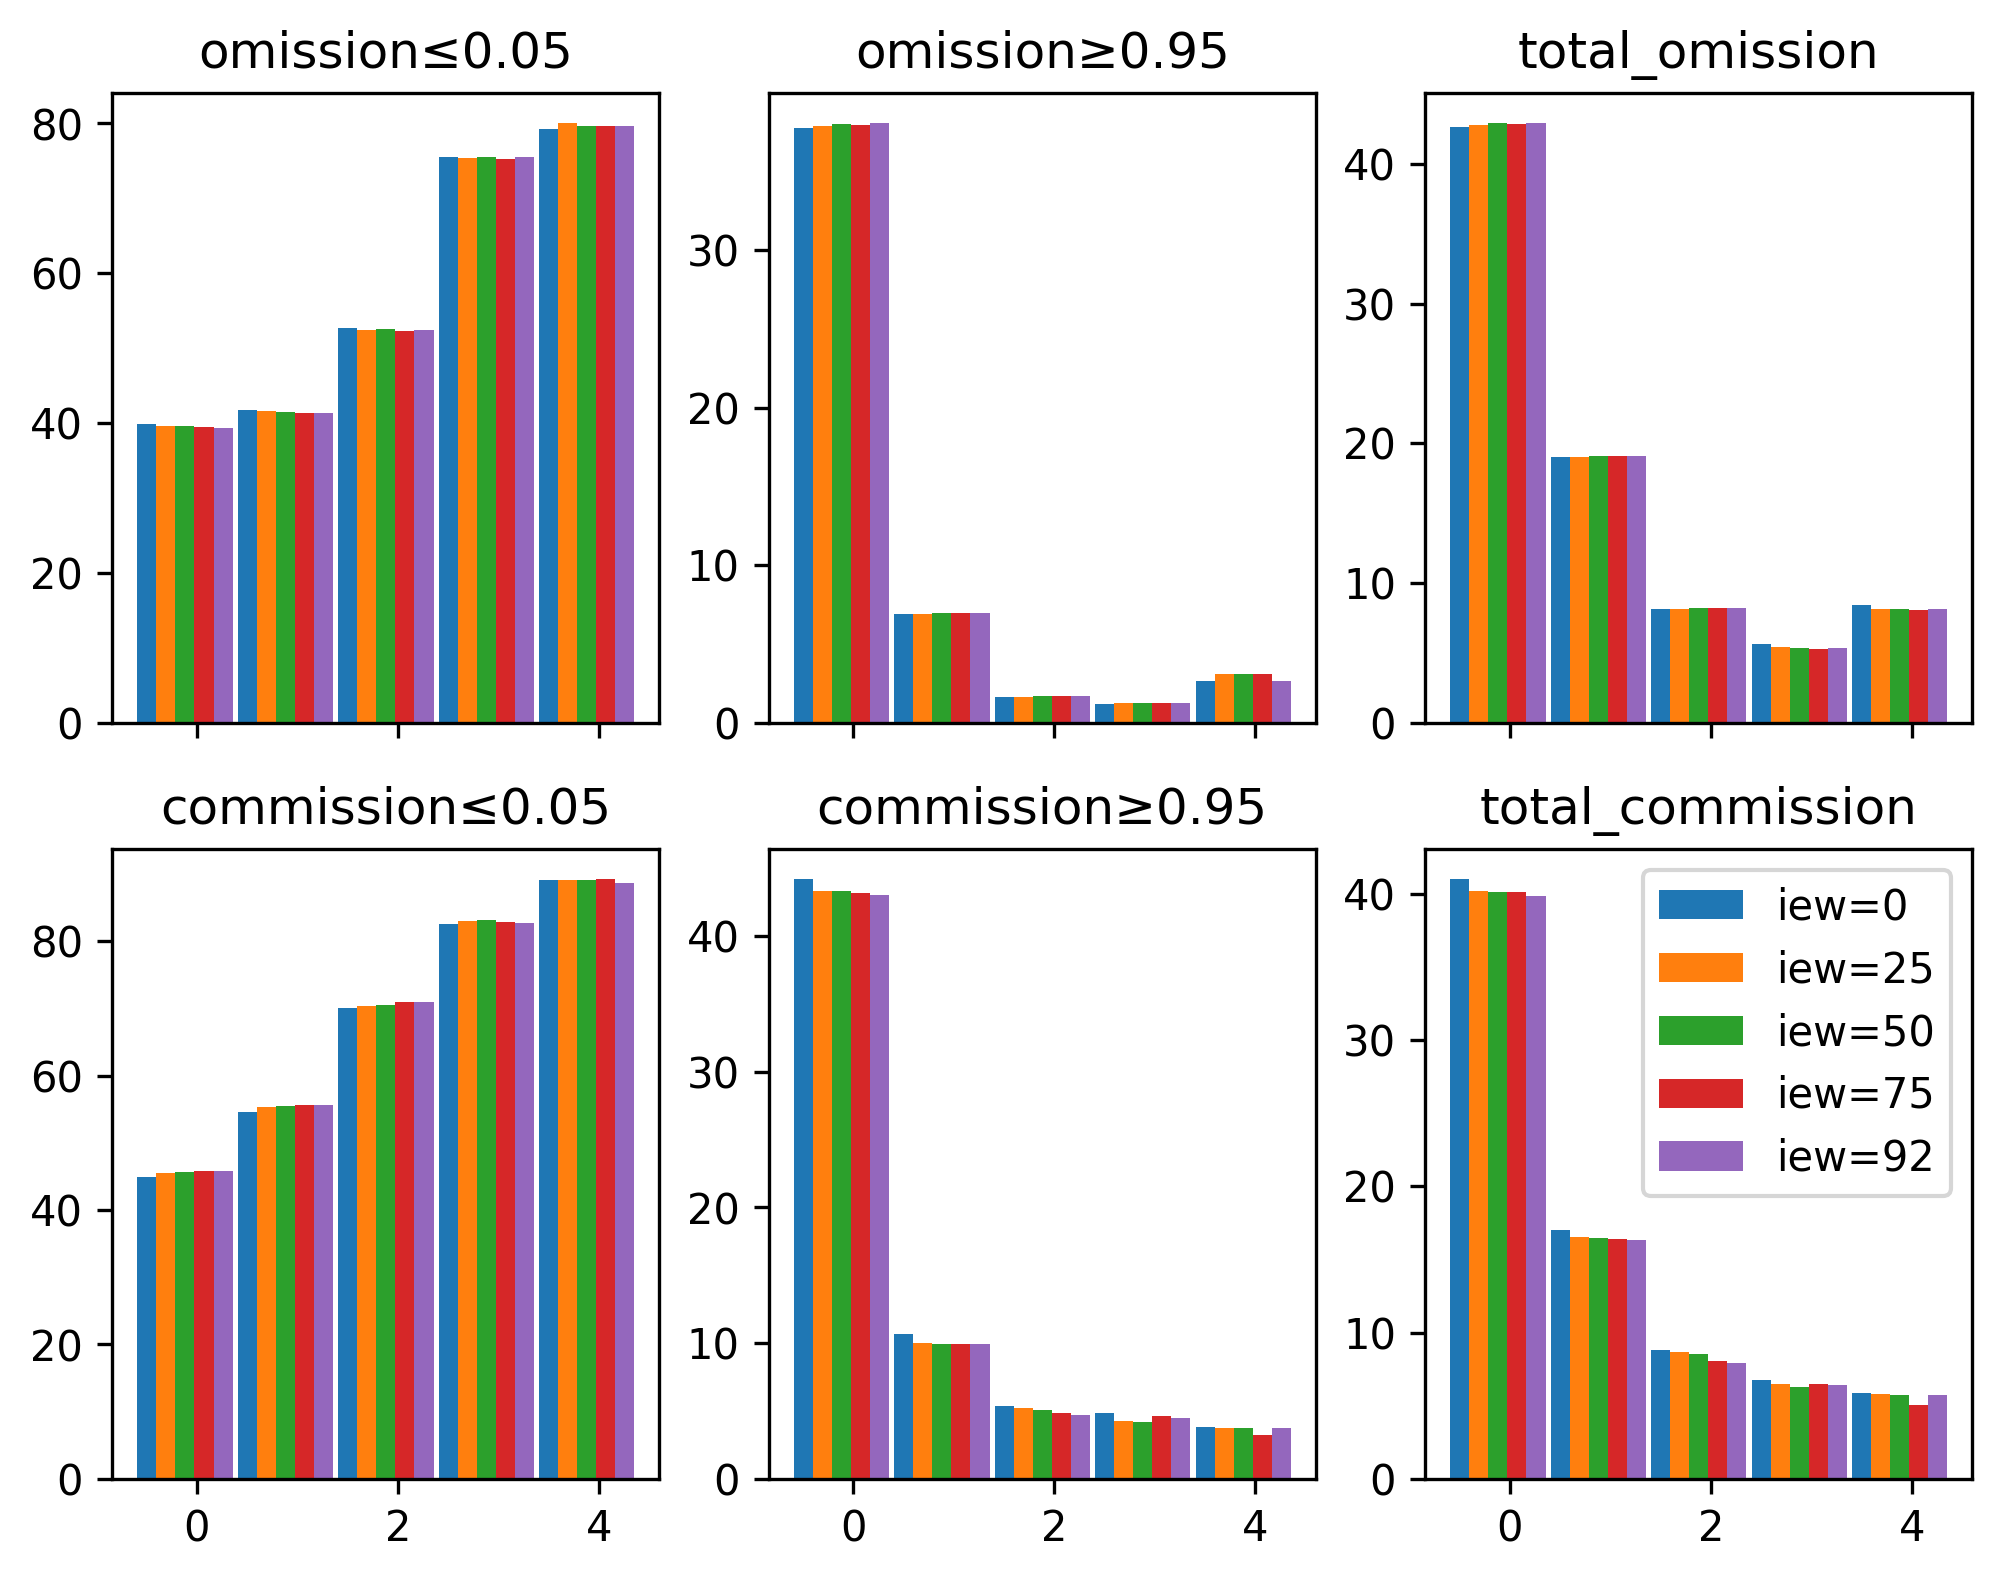

In [44]:
iew_list=[0,25,50,75,92]
fig, axes = plt.subplots(2,3, figsize=(8,6), sharex=True, sharey=False, dpi=300)
offset = -0.5
width=0.19
xtick=np.array(range(0,5))

def step_plot(ax,count,field,iew):
    ax.bar(xtick-0.5+width*count,ie[:5][field],width=width,linewidth=0.5,label='iew={}'.format(iew))
    ax.set_title(field)
c=0
for iew in iew_list:
    ie=pd.read_csv(r'D:\evaluate\model_768_240116\evaluate_iew{}.csv'.format(iew))
    step_plot(axes[0,0],c,'omission≤0.05',iew)
    step_plot(axes[0,1],c,'omission≥0.95',iew)
    step_plot(axes[0,2],c,'total_omission',iew)
    step_plot(axes[1,0],c,'commission≤0.05',iew)
    step_plot(axes[1,1],c,'commission≥0.95',iew)
    step_plot(axes[1,2],c,'total_commission',iew)
    plt.legend()
    c=c+1